In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!git clone https://github.com/chandniagarwal/Gan_Classifier.git

Cloning into 'Gan_Classifier'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 70 (delta 19), reused 65 (delta 14), pack-reused 0
Receiving objects: 100% (70/70), 3.85 MiB | 28.80 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [9]:
!mkdir training
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/recon /content/training/recon
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/celebagt /content/training/ground
!cp -r /content/drive/MyDrive/researchwork_15.9.203/testing /content/testing

In [10]:
import sys
sys.path.append('/content/Gan_Classifier/src')
import glob
import os
import numpy as np
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers


from keras.models import Sequential
from keras.layers import Input, Dense, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time
import random
import seaborn as sns
from DatasetCreation import DatasetCreation
from Model import Model
from ElmModel import elm
from numba import cuda

In [11]:
tf.random.set_seed(
    42
)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
list_images=[]
labels=[]

In [12]:
# Testing Data Location
test_gt = "/content/drive/MyDrive/researchwork_15.9.203/testing/gt"
test_gen = "/content/drive/MyDrive/researchwork_15.9.203/testing/gen"
test_ec = "/content/drive/MyDrive/researchwork_15.9.203/testing/ec"
test_vqvae = "/content/drive/MyDrive/researchwork_15.9.203/testing/vqvae"
test_mask = "/content/drive/MyDrive/imageclassificationmodel/dataset/mask2000"
test_unmask = "/content/drive/MyDrive/imageclassificationmodel/dataset/gt2000"

In [13]:
# test_gt = '/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/e3'
# test_vqvae='/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/g3'

In [14]:
# Training Data Location
train_gt='/content/training/ground'
train_recon='/content/training/recon'

In [15]:
# training Data
image_loc_ground = glob.glob(train_gt+"/*.jpg")
labels = len(image_loc_ground) * ["ground"]
image_loc_recon = glob.glob(train_recon+"/*.jpg")

labels += len(image_loc_recon) * ["recon"]
image_loc = image_loc_ground + image_loc_recon

training_dataset = DatasetCreation(image_loc, labels, "one_hot")
# for 152 layer
training_dataset_152_layer = DatasetCreation(
    image_loc, labels, "one_hot", tf.keras.applications.resnet50.preprocess_input
)
print(training_dataset.images.shape)
print(training_dataset.labels.shape)

_________Loading Images__________


100%|██████████| 7178/7178 [00:23<00:00, 305.04it/s]


_________Loading Images__________


100%|██████████| 7178/7178 [00:12<00:00, 565.77it/s]


(7178, 224, 224, 3)
(7178, 2)


## Load Softmax Model

In [16]:
def load_model(model_function, layers_to_train):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = False

  for layer in layers_to_train:
    base_model.get_layer(layer).trainable = True


  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [17]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_vgg_16_full = load_model(tf.keras.applications.vgg16.VGG16, ["block5_conv3"])
model_vgg_19_full = load_model(tf.keras.applications.vgg19.VGG19, ["block5_conv3"])

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, [])
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, [])
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, [])
model_vgg_16_freeze = load_model(tf.keras.applications.vgg16.VGG16, [])
model_vgg_19_freeze = load_model(tf.keras.applications.vgg19.VGG19, [])

234698864/234698864 [==============================] - 8s 0us/step
Running time: 15.4758 seconds
171446536/171446536 [==============================] - 5s 0us/step
Running time: 8.5580 seconds
94765736/94765736 [==============================] - 3s 0us/step
Running time: 4.3108 seconds
58889256/58889256 [==============================] - 2s 0us/step
Running time: 2.9069 seconds
80134624/80134624 [==============================] - 3s 0us/step
Running time: 3.7436 seconds
Running time: 4.5653 seconds
Running time: 2.8826 seconds
Running time: 1.5176 seconds
Running time: 0.3177 seconds
Running time: 0.3847 seconds


In [18]:
# best model calculate before the notebook crashed
model_resnet_152_full.load_weights('/content/drive/MyDrive/final_model/checkpoint/Resnet_152_full/weights.06-0.32-0.85.hdf5')
model_resnet_101_full.load_weights('/content/drive/MyDrive/final_model/checkpoint/Resnet_101_full/weights.06-0.73-0.51.hdf5')
model_resnet_50_full.load_weights('/content/drive/MyDrive/final_model/checkpoint/Resnet_50_full/weights.03-0.61-0.69.hdf5')
model_resnet_152_freeze.load_weights('/content/drive/MyDrive/final_model/checkpoint/Resnet_152_freeze/weights.06-0.40-0.80.hdf5')
model_resnet_101_freeze.load_weights('/content/drive/MyDrive/final_model/checkpoint/Resnet_101_freeze/weights.06-0.73-0.47.hdf5')
model_resnet_50_freeze.load_weights('/content/drive/MyDrive/final_model/checkpoint/Resnet_50_freeze/weights.06-0.73-0.50.hdf5')
model_vgg_16_full.load_weights('/content/drive/MyDrive/final_model/checkpoint/VGG_16_full/weights.06-0.07-0.97.hdf5')
model_vgg_19_full.load_weights('/content/drive/MyDrive/final_model/checkpoint/VGG_19_full/weights.07-0.16-0.94.hdf5')
model_vgg_16_freeze.load_weights('/content/drive/MyDrive/final_model/checkpoint/VGG_16_freeze/weights.03-0.65-0.61.hdf5')
model_vgg_19_freeze.load_weights('/content/drive/MyDrive/final_model/checkpoint/VGG_19_freeze/weights.03-0.58-0.70.hdf5')

In [26]:
model_softmax = {
    "Resnet_152_full": model_resnet_152_full,
    "Resnet_101_full": model_resnet_101_full,
    "Resnet_50_full": model_resnet_50_full,
    "Resnet_152_freeze": model_resnet_152_freeze,
    "Resnet_101_freeze": model_resnet_101_freeze,
    "Resnet_50_freeze": model_resnet_50_freeze,
    "VGG_16_full": model_vgg_16_full,
    "VGG_19_full": model_vgg_19_full,
    "VGG_16_freeze": model_vgg_16_freeze,
    "VGG_19_freeze": model_vgg_19_freeze,
}
model_data_train = {
    "Resnet_152_full": training_dataset_152_layer,
    "Resnet_101_full": training_dataset,
    "Resnet_50_full": training_dataset,
    "Resnet_152_freeze": training_dataset_152_layer,
    "Resnet_101_freeze": training_dataset,
    "Resnet_50_freeze": training_dataset,
    "VGG_16_full": training_dataset,
    "VGG_19_full": training_dataset,
    "VGG_16_freeze": training_dataset,
    "VGG_19_freeze": training_dataset,
}

In [30]:
for key in model_softmax.keys():
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")

## Load Test Data

In [22]:
# test Data
image_loc_ground = glob.glob(test_gt+"/*.jpg")
label_ground = len(image_loc_ground) * ["ground"]

image_loc_gen = glob.glob(test_gen+"/*.jpg")
label_gen = len(image_loc_gen) * ["recon"]

image_loc_ec = glob.glob(test_ec+"/*.jpg")
label_ec = len(image_loc_ec) * ["recon"]

image_loc_vqvae = glob.glob(test_vqvae+"/*.jpg")
label_vqvae = len(image_loc_vqvae) * ["recon"]

test_dataset = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary"
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary"
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary"
        ),
}

test_dataset_152_layer = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
}
model_data = {
    "Resnet_152_full": test_dataset_152_layer,
    "Resnet_101_full": test_dataset,
    "Resnet_50_full": test_dataset,
    "Resnet_152_freeze": test_dataset_152_layer,
    "Resnet_101_freeze": test_dataset,
    "Resnet_50_freeze": test_dataset,
    "VGG_16_full": test_dataset,
    "VGG_19_full": test_dataset,
    "VGG_16_freeze": test_dataset,
    "VGG_19_freeze": test_dataset,
}

_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 206.42it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 222.54it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 220.48it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 308.84it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 306.54it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 296.02it/s]


## Softmax ELM

In [31]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

In [32]:
def batch_predict(model, images, batch=32):
  array1 = []
  for idx in range(0, len(images), batch):
    array2 = model.predict(images[idx: min(len(images), idx+batch)], verbose = 0)

    if len(array1)>0:
      array1 = np.concatenate((array1, array2), axis=0)
    else:
      array1 = array2
  return array1

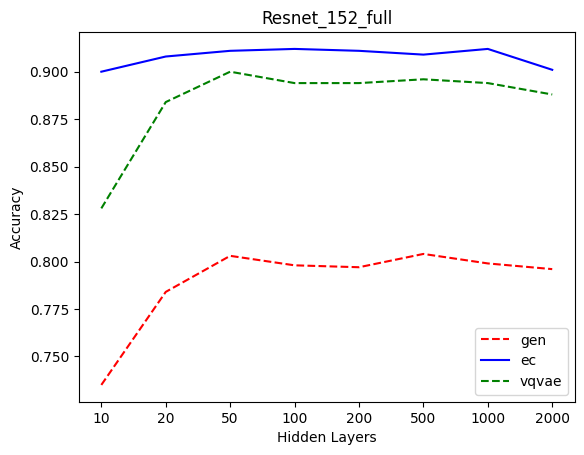

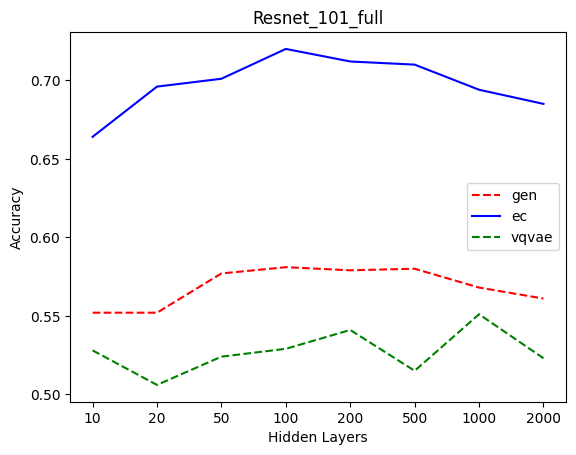

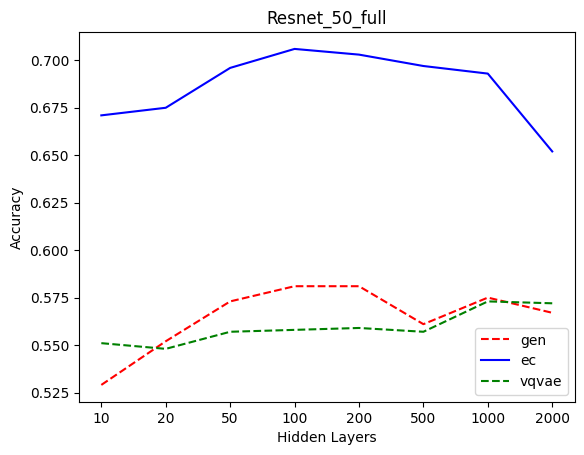

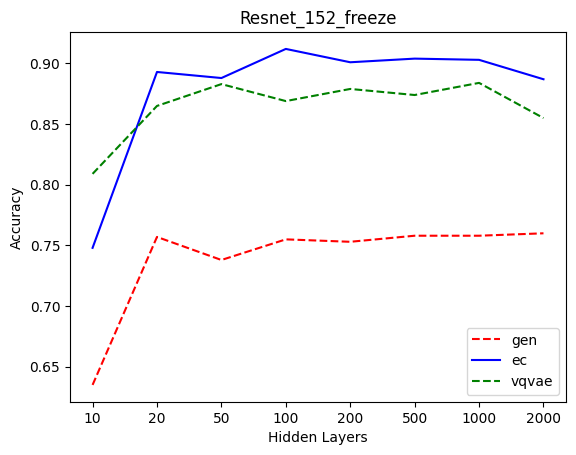

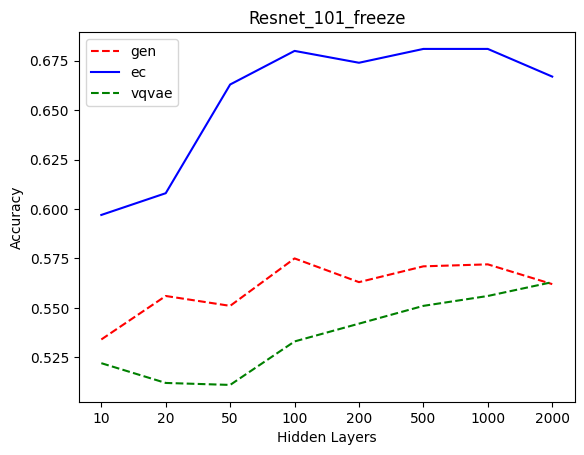

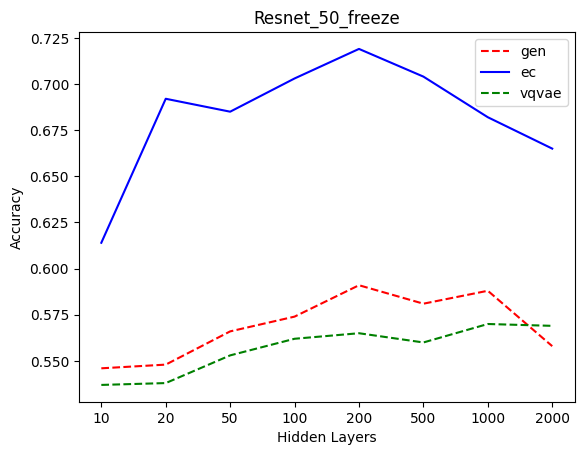

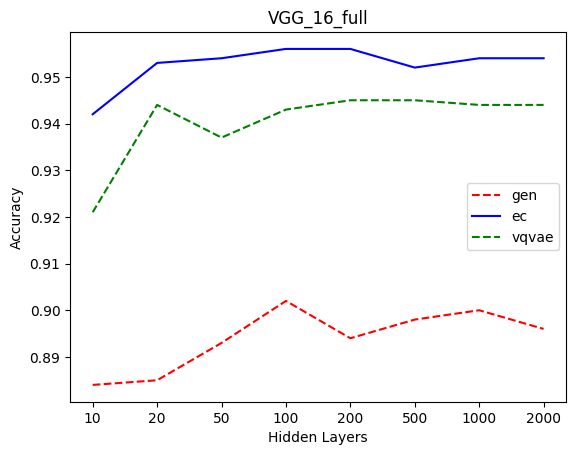

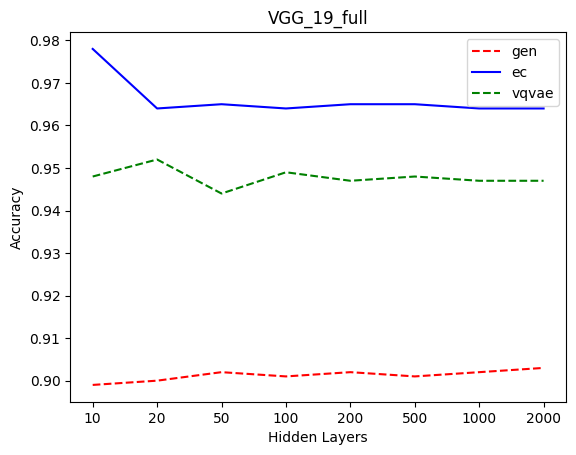

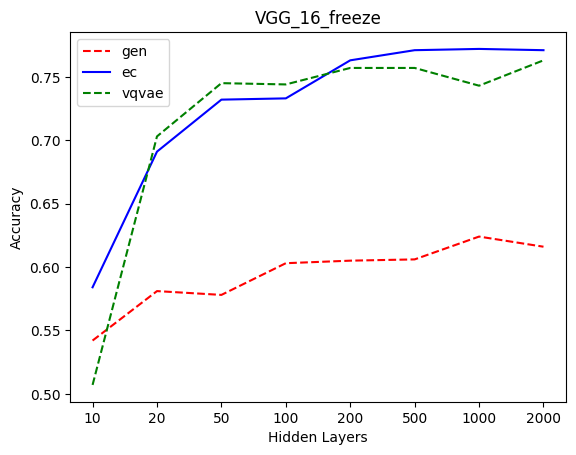

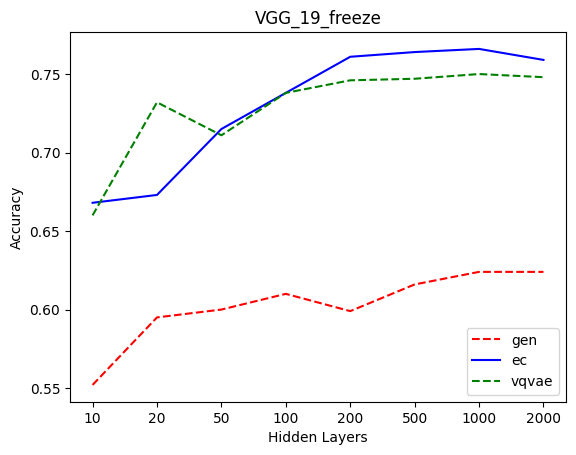

In [35]:
for model_name in model_softmax.keys():
  Xtrain = batch_predict(model_softmax[model_name].headless_model, model_data_train[model_name].images, 32)
  Ytrain = model_data_train[model_name].labels[...,0] == 0

  accuracy = {}
  hidden_layers = [10,20,50,100,200,500,1000,2000]

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 32)
    for layer in hidden_layers:
      model_elm = elm(hidden_units=layer, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
      beta, train_accuracy, running_time = model_elm.fit('solution2')
      y_result = model_elm.predict(Xtest)
      labels = model_data[model_name][key].labels
      acc_sp = accuracy.get(key, [])
      acc_sp.append(accuracy_score(y_result, labels))
      accuracy[key] = acc_sp

  # Visualize Test Accuracy
  hidden_layer_range = range(len(hidden_layers))
  plt.title(model_name)
  plt.plot(hidden_layer_range, accuracy["gen"], 'r--')
  plt.plot(hidden_layer_range, accuracy["ec"], 'b-')
  plt.plot(hidden_layer_range, accuracy["vqvae"], 'g--')
  plt.xticks(hidden_layer_range, hidden_layers)
  plt.legend(['gen', 'ec', 'vqvae'])
  plt.xlabel('Hidden Layers')
  plt.ylabel('Accuracy')
  plt.show();

## Load Sigmoid Model

In [36]:
def load_model(model_function, layers_to_train):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = False

  for layer in layers_to_train:
    base_model.get_layer(layer).trainable = True


  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [37]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_vgg_16_full = load_model(tf.keras.applications.vgg16.VGG16, ["block5_conv3"])
model_vgg_19_full = load_model(tf.keras.applications.vgg19.VGG19, ["block5_conv3"])

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, [])
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, [])
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, [])
model_vgg_16_freeze = load_model(tf.keras.applications.vgg16.VGG16, [])
model_vgg_19_freeze = load_model(tf.keras.applications.vgg19.VGG19, [])

Running time: 5.4340 seconds
Running time: 3.1754 seconds
Running time: 1.6508 seconds
Running time: 0.3356 seconds
Running time: 0.4085 seconds
Running time: 4.6022 seconds
Running time: 3.1853 seconds
Running time: 1.6061 seconds
Running time: 0.3244 seconds
Running time: 0.4080 seconds


In [38]:
# best model calculate before the notebook crashed
model_resnet_152_full.load_weights('/content/drive/MyDrive/final_model/checkpoint_sigmoid/Resnet_152_full/weights.06-0.44-0.82.hdf5')
model_resnet_101_full.load_weights('/content/drive/MyDrive/final_model/checkpoint_sigmoid/Resnet_101_full/weights.06-0.82-0.42.hdf5')
model_resnet_50_full.load_weights('/content/drive/MyDrive/final_model/checkpoint_sigmoid/Resnet_50_full/weights.03-0.67-0.62.hdf5')
model_resnet_152_freeze.load_weights('/content/drive/MyDrive/final_model/checkpoint_sigmoid/Resnet_152_freeze/weights.08-0.35-0.82.hdf5')
model_resnet_101_freeze.load_weights('/content/drive/MyDrive/final_model/checkpoint_sigmoid/Resnet_101_freeze/weights.06-0.73-0.47.hdf5')
model_resnet_50_freeze.load_weights('/content/drive/MyDrive/final_model/checkpoint_sigmoid/Resnet_50_freeze/weights.06-0.71-0.53.hdf5')
model_vgg_16_full.load_weights('/content/drive/MyDrive/final_model/checkpoint_sigmoid/VGG_16_full/weights.08-0.05-0.98.hdf5')
model_vgg_19_full.load_weights('/content/drive/MyDrive/final_model/checkpoint_sigmoid/VGG_19_full/weights.07-0.19-0.93.hdf5')
model_vgg_16_freeze.load_weights('/content/drive/MyDrive/final_model/checkpoint_sigmoid/VGG_16_freeze/weights.06-0.62-0.65.hdf5')
model_vgg_19_freeze.load_weights('/content/drive/MyDrive/final_model/checkpoint_sigmoid/VGG_19_freeze/weights.03-0.60-0.68.hdf5')

In [39]:
model_softmax = {
    "Resnet_152_full": model_resnet_152_full,
    "Resnet_101_full": model_resnet_101_full,
    "Resnet_50_full": model_resnet_50_full,
    "Resnet_152_freeze": model_resnet_152_freeze,
    "Resnet_101_freeze": model_resnet_101_freeze,
    "Resnet_50_freeze": model_resnet_50_freeze,
    "VGG_16_full": model_vgg_16_full,
    "VGG_19_full": model_vgg_19_full,
    "VGG_16_freeze": model_vgg_16_freeze,
    "VGG_19_freeze": model_vgg_19_freeze,
}
model_data_train = {
    "Resnet_152_full": training_dataset_152_layer,
    "Resnet_101_full": training_dataset,
    "Resnet_50_full": training_dataset,
    "Resnet_152_freeze": training_dataset_152_layer,
    "Resnet_101_freeze": training_dataset,
    "Resnet_50_freeze": training_dataset,
    "VGG_16_full": training_dataset,
    "VGG_19_full": training_dataset,
    "VGG_16_freeze": training_dataset,
    "VGG_19_freeze": training_dataset,
}

In [40]:
for key in model_softmax.keys():
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")

## Elm Sigmoid

In [41]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

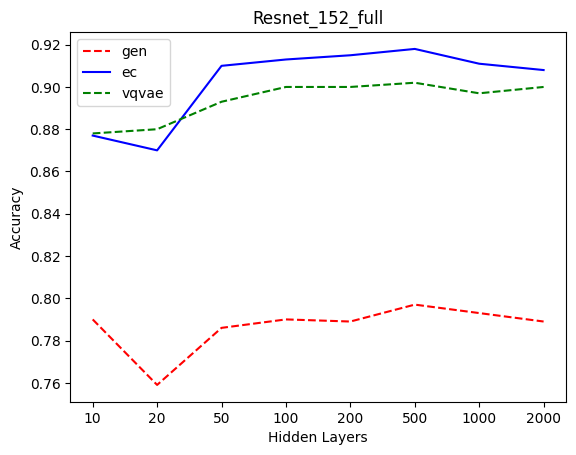

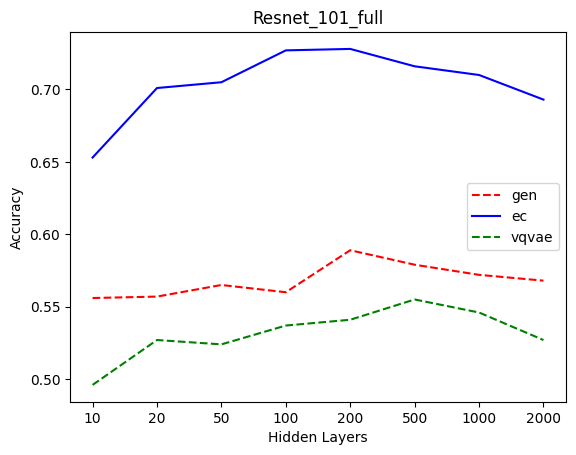

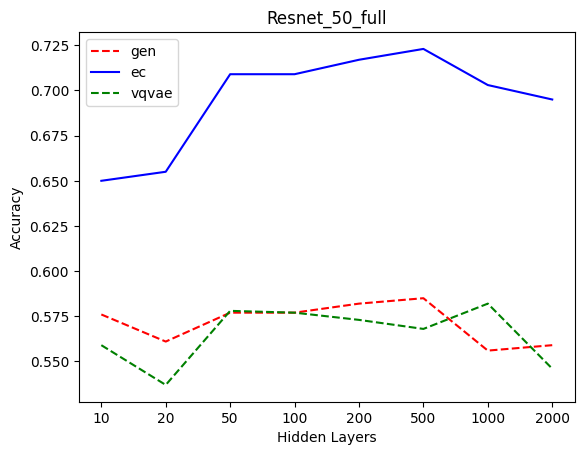

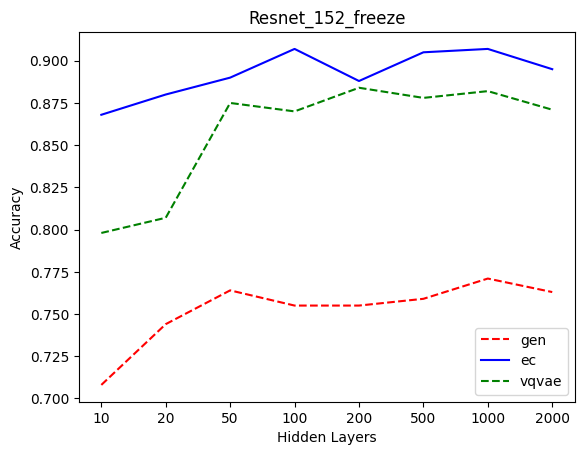

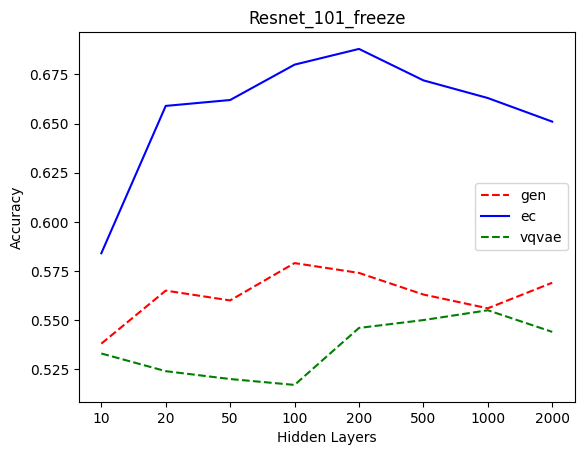

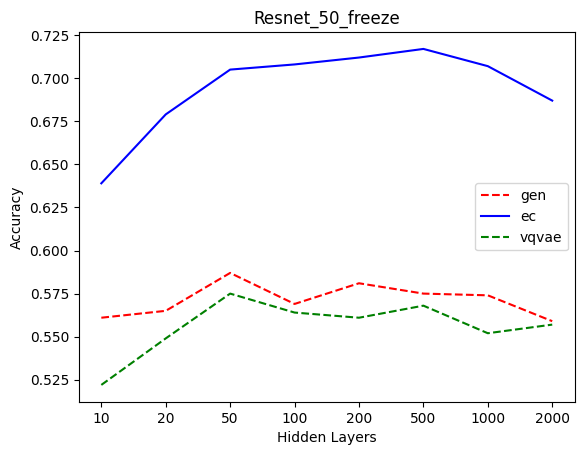

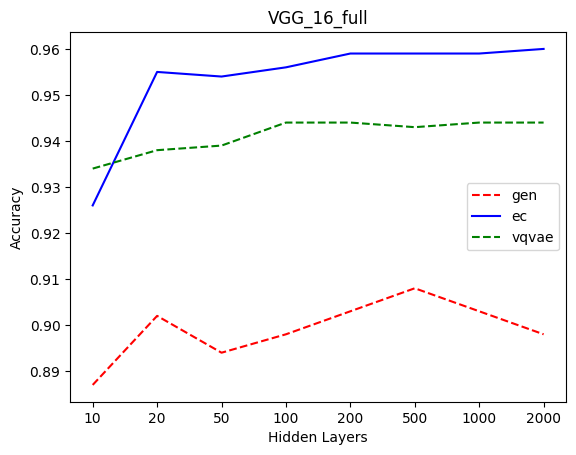

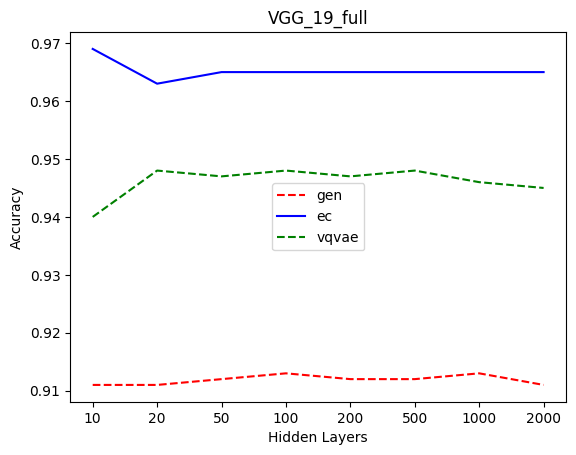

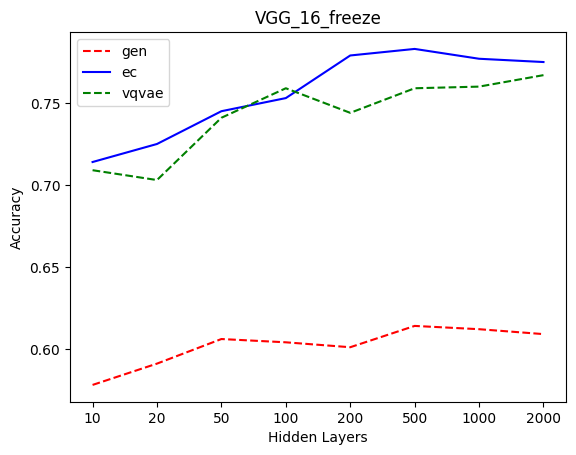

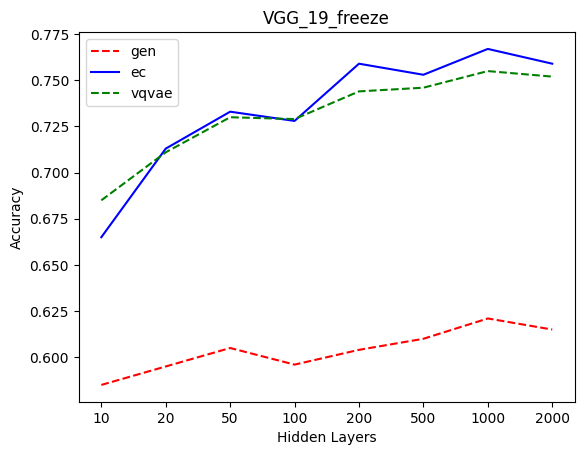

In [42]:
for model_name in model_softmax.keys():
  Xtrain = batch_predict(model_softmax[model_name].headless_model, model_data_train[model_name].images, 64)
  Ytrain = model_data_train[model_name].labels[...,0] == 0

  accuracy = {}
  hidden_layers = [10,20,50,100,200,500,1000,2000]

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    for layer in hidden_layers:
      model_elm = elm(hidden_units=layer, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
      beta, train_accuracy, running_time = model_elm.fit('solution2')
      y_result = model_elm.predict(Xtest)
      labels = model_data[model_name][key].labels
      acc_sp = accuracy.get(key, [])
      acc_sp.append(accuracy_score(y_result, labels))
      accuracy[key] = acc_sp

  # Visualize Test Accuracy
  hidden_layer_range = range(len(hidden_layers))
  plt.title(model_name)
  plt.plot(hidden_layer_range, accuracy["gen"], 'r--')
  plt.plot(hidden_layer_range, accuracy["ec"], 'b-')
  plt.plot(hidden_layer_range, accuracy["vqvae"], 'g--')
  plt.xticks(hidden_layer_range, hidden_layers)
  plt.legend(['gen', 'ec', 'vqvae'])
  plt.xlabel('Hidden Layers')
  plt.ylabel('Accuracy')
  plt.show();